# **Finding Lane Lines on the Road** 

## Writeup Template

### Student Name: Yi Qin([qshangwu@163.com]( mailto:qshangwu@163.com))

---

**Finding Lane Lines on the Road**

The goals / steps of this project are the following:
* Make a pipeline that finds lane lines on the road
* Reflect on your work in a written report


[//]: # (Image References)

[image1]: ./examples/grayscale.jpg "Grayscale"

---

### Reflection

### 1. General introduction of the lane finding algorithm.

My thought consist of following steps:  

**Firstly, image marking:**
* Step1 Change image from color to gray  
* Step2 Blur/smooth the gray image to remove some high frequency noise  
* Step3 Create image mask to remove some nuwanted area
* Step4 Find lines on the processed gray image and try to use line gradient to identify left and right lane  
* Step5 Combine line image and real image to mark the lanes  

**Secondly,use same method on stream video:**
  
#### Pre-step1. Libuary Import and function setup

**import some libs for image processing

In [64]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image  


**And I also copy the code from the templete to create some functions:**

`grayscale()` change image into grayscale  
`gaussian_blur()` smooth image to remove some high frenquency noise  
`canny()` to find edges from the gray image. High/low threshold must be set  
`region_of_interest()` set mask and cut to keep image in the mask  
`hough_lines()` identify lines from the masked image  
`draw_lines()` make a pipline on the image  
`weighted_img()` combine lines and real image togather  

In [60]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, A=0.8, B=1., G=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, A, img, B, G)

And we also make a list of parameters for above functions.  
Note the following paramters are tried multiple times to make output image looks good and meet requirement

In [58]:
kernel_size = 3 # for gaussian blur function
mask_vertices = np.array([[(456,325),(0,540), (960,540), (514,325)]], dtype=np.int32)# make a quadrilateral shape mask

#set thresholds for canny edge finding
low_threshold = 50
high_threshold = 150

#set parameters for hough_lines() function
rho = 2
theta = np.pi/180
threshold = 15
min_line_len = 30
max_line_gap = 10

#### Step1. Image loading in  and pretreatment(gray, blur and masking)
Firstly, we get all images file name and put them into `files`and set output folder as "test_image_output"

In [ ]:
input_folder = "test_images/"
output_folder ="test_images_output/"

files = os.listdir(input_folder)

#make a iteration to process all images in the folder
for file_item in files:
    image = mpimg.imread(input_folder + file_item)
    process_image = np.copy(image) # make a copy from the orignal image
    

#### Stpe2 Preliminary process on loaded image

In this part, we firstly change image to gray scale. Then blur the image with tested kernal size with GaussianBlur function. After that, we use Canny function to find the edge points in the gray image. And finally make a mask to cut unwanted area.

In [ ]:
    gray_image = grayscale(process_image)# change image to gray scale
    blur_image = gaussian_blur(gray_image, kernel_size)# smooth image to remove high frequency noise/features
    edges = canny(blur_image,low_threshold, high_threshold)# find edge dots in the image
    masked_edges = region_of_interest(edges, mask_vertices) # define a image mask and cut edges
    

#### Stpe3 Find lines and image combine

after basic process, we find some lines based on edge points. And combine the image with original one.

In [73]:
    #find the line in the image(from canny + masked process)
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    comb_image = weighted_img(image,line_image) # combine original image and line togather
    #change RGB space to BGR to correct the output
    bgr_image = comb_image[...,::-1]
    

    cv2.imwrite(output_folder + file_item,bgr_image) #save marked image to the folder

True

After image procesing, we can get some segment marked lines on the lane:  


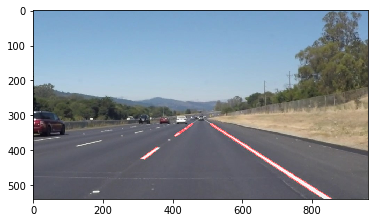

In [74]:
image_sample = mpimg.imread("./test_images_output/solidWhiteRight.jpg") # display a sample of marked image after processed
plt.imshow(image_sample)
plt.show()

### Stpe2 Change image to gray and blur them

In order to draw a single line on the left and right lanes, I modified the draw_lines() function by ...

If you'd like to include images to show how the pipeline works, here is how to include an image: 

![alt "gray"][image1]


### 2. Identify potential shortcomings with your current pipeline


One potential shortcoming would be what would happen when ... 

Another shortcoming could be ...


### 3. Suggest possible improvements to your pipeline

A possible improvement would be to ...

Another potential improvement could be to ...